# train.py: What it does step by step

This tutorial will break down what train.py does when it is run, and illustrate the functionality of some of the custom 'proloaf' functions that are called during a training run, in a way that is easy to understand and follow.

Note that parts of the functionality of train.py depend on the config.json file you are using. This tutorial is self-contained, and doesn't use a config file, but for more information on working with this file when using ProLoaF, see [this explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/). Before proceeding to any of the sections below, please run the following code block:


In [1]:
import os
import sys
sys.path.append("../")
import pandas as pd
import proloaf.datahandler as dh
import matplotlib.pyplot as plt
import numpy as np

## Table of contents:

[1. Dealing with missing values in the data](#1.-Dealing-with-missing-values-in-the-data)

[2. Selecting and scaling features](#2.-Selecting-and-scaling-features)

[3. Creating a dataframe to log training results](#3.-Creating-a-dataframe-to-log-training-results)

[4. Exploration](#4.-Exploration)

[5. Main run - creating the training model](#5.-Main-run---creating-the-training-model)

[6. Main run - training the model](#6.-Main-run---training-the-model)

[7. Updating the config, Saving the model & logs](#7.-Updating-the-config,-saving-the-model-&-logs)


## 1. Dealing with missing values in the data

The first thing train.py does after loading the dataset that was specified in your config file, is to check for any missing values, and fill them in as necessary. It does this using the function 'proloaf.datahandler.fill_if_missing'. In the following example, we will load some data that has missing values and examine what the 'fill_if_missing' function does. Please run the code block below to get started.

<AxesSubplot:>

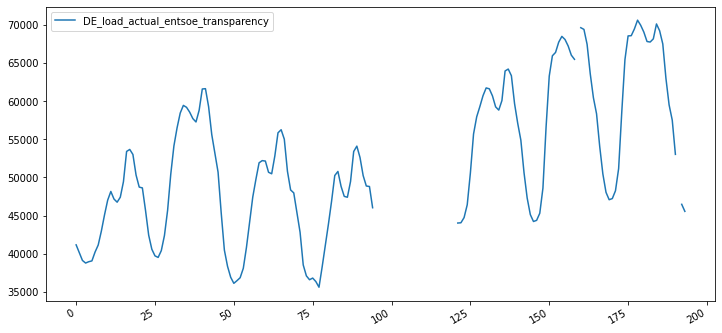

In [2]:
#Load the data sample and prep for use with datahandler functions
df = pd.read_csv("../data/fill_missing.csv", sep=";")
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.astype(float)
df_missing_range = df.copy()

#Plot the data
df.iloc[0:194].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), xlabel='Hours', use_index = False)

As should be clearly visible in the plot above, the data has some missing values. There is a missing range (a range refers to multiple adjacent values), from around 96-121, as well as two individual values that are missing, at 160 and 192. Please run the code block below to see how 'fill_if_missing' deals with these problems.

In [ ]:
#Use fill_if_missing and plot the results

df=dh.fill_if_missing(df, periodicity=24)
df.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False)
#TODO: Test this again once interpolation is working

As we can see by the printed console messages, fill_if_missing first checks whether there are any missing values. If there are, it checks whether they are individual values or ranges, and handles these cases differently: 

### Single missing values:
These are simply replaced by the average of the values on either side.

### Missing range:
If a range of values is missing, fill_if_missing will use the specified periodicity of the data to provide an estimate of the missing values, by averaging the ranges on either side of the missing range and then adapting the new values to fit the trend. If not specified, the periodicity has a default value of 1, but since we are using hourly data, we will use a periodicity of p = 24.

For each missing value at a given position t in the range, fill_if_missing first searches backwards through the data at intervals equal to the periodicity of the data (i.e. t1 = t - 24\*n, n = 1, 2,...) until it finds an existing value. It then does the same thing searching forwards through the data (i.e. t2 = t + 24\*n, n = 1, 2,...), and then it sets the value at t equal to the average of t1 and t2. Run the code block below to see the result for the missing range at 95-121:

<AxesSubplot:>

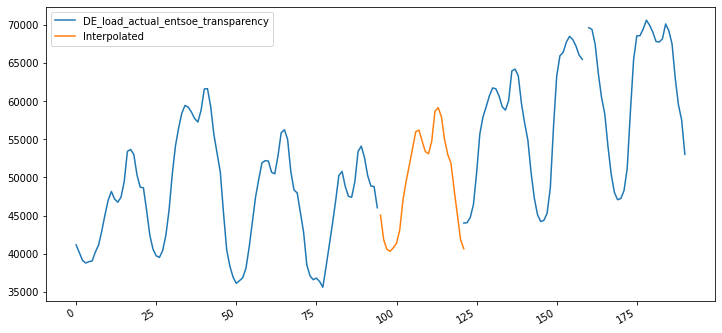

In [4]:
start = 95
end = 121
p = 24
seas = np.zeros(len(df_missing_range))

#fill the missing values
for t in range(start, end + 1):
    p1 = p
    p2 = p
    while np.isnan(df_missing_range.iloc[t - p1, 0]):
        p1 += p
    while np.isnan(df_missing_range.iloc[t + p2, 0]):
        p2 += p

    seas[t] = (df_missing_range.iloc[t - p1, 0] + df_missing_range.iloc[t + p2, 0]) / 2

#plot the result
ax = plt.gca()
df_missing_range["Interpolated"] = pd.Series(len(seas))
for t in range(start, end + 1):
    df_missing_range.iloc[t, 1] = seas[t]
df_missing_range.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False, ax = ax)
df_missing_range.iloc[0:192].plot(kind='line',y='Interpolated', figsize = (12, 6), use_index = False, ax = ax)

The missing values in the range between 95 and 121 have now been filled in, but the end points aren't continuous with the original data, and the new values don't take into account the trend in the data. To deal with this, the function uses the difference in slope between the start and end points of the missing data range, and the start and end points of the newly interpolated values, to offset the new values so that they line up with the original data:

Create two straight lines that connect the interpolated start and end points, and the original start and end points.
These capture the 'trend' in each case over the missing section


<AxesSubplot:>

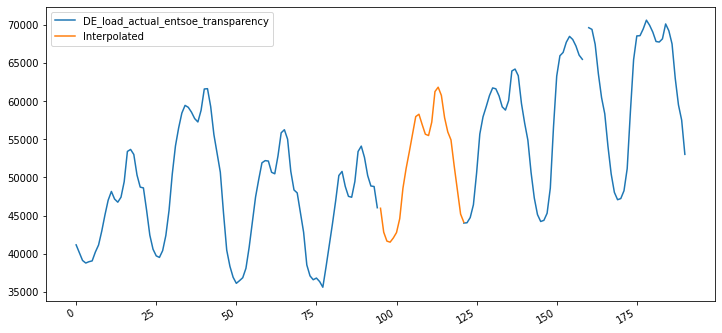

In [5]:
print("Create two straight lines that connect the interpolated start and end points, and the original start and end points.\nThese capture the 'trend' in each case over the missing section")
trend1 = np.poly1d(
    np.polyfit([start, end], [seas[start], seas[end]], 1)
)
trend2 = np.poly1d(
    np.polyfit(
        [start - 1, end + 1],
        [df_missing_range.iloc[start - 1, 0], df_missing_range.iloc[end + 1, 0]],
        1,
    )
)

#by subtracting the trend of the interpolated data, then adding the trend of the original data, we match the filled in
#values to what we had before
for t in range(start, end + 1):
    df_missing_range.iloc[t, 1] = seas[t] - trend1(t) + trend2(t)
    
#plot the result
ax = plt.gca()
df_missing_range.iloc[0:192].plot(kind='line',y='DE_load_actual_entsoe_transparency', figsize = (12, 6), use_index = False, ax = ax)
df_missing_range.iloc[0:192].plot(kind='line',y='Interpolated', figsize = (12, 6), use_index = False, ax = ax)

**Please note:**
- Missing data ranges at the beginning or end of the data are handled differently (TODO: Explain how)
- Though the examples shown here use a single column for simplicity's sake, fill_if_missing automatically works on every column (feature) of your original dataframe. 

## 2. Selecting and scaling features

The next thing train.py does is to select and scale features in the data as specified in the relevant config file, using the function 'proloaf.datahandler.scale_all'.

Consider the following dataset:

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_sin,hour_cos,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,5946.0,41151.0,-6.503,0.0,0.0,-0.981,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 01:00:00,5726.0,40135.0,-6.458,0.0,0.0,-1.035,0.0,0.0,0.258819,0.965926,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 02:00:00,5347.0,39106.0,-6.253,0.0,0.0,-1.109,0.0,0.0,0.500000,0.866025,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 03:00:00,5249.0,38765.0,-5.908,0.0,0.0,-1.166,0.0,0.0,0.707107,0.707107,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 04:00:00,5309.0,38941.0,-5.516,0.0,0.0,-1.226,0.0,0.0,0.866025,0.500000,...,0,0,0,0,0,0,1,0,0,0


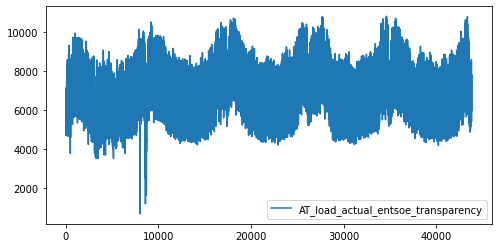

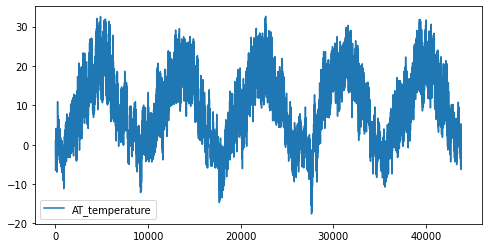

In [6]:
#Load and then plot the new dataset
df_to_scale = pd.read_csv("../data/opsd.csv", sep=";", index_col=0)

df_to_scale.plot(kind='line',y='AT_load_actual_entsoe_transparency', figsize = (8, 4), use_index = False)
df_to_scale.plot(kind='line',y='AT_temperature', figsize = (8, 4), use_index = False)
df_to_scale.head()

The above dataset has 55 features (columns), some of which are at totally different scales, as is clearly visible when looking at the y-axes of the above graphs for load and temperature data from Austria. 

Depending on our dataset, we may not want to use all of the available features for training. 
If we wanted to select only the two features highlighted above for training, we could do so by editing the value at the "feature_groups" key in the config.json, which takes the form of a list of dicts like the one below:

In [7]:
two_features = [
    {
        "name": "main",
        "scaler": [
            "minmax",
            -1.0,
            1.0
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
            "AT_temperature"
        ]
    }
]

Each dict in the list represents a feature group, and should have the following keys:
- "name" - the name of the feature group
- "scaler" - the scaler used by this feature group (value: a list with entries for scaler name and scaler specific attributes.) Valid scaler names include 'standard', 'robust' or 'minmax'. For more information on these scalers and their use, please see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) or [the documentation for scale_all](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/reference/proloaf/proloaf/utils/datahandler.html#scale_all)
- "features" - which features are to be included in the group (value: a list containing the feature names)

The 'scale_all' function will only return the selected features, scaled using the scaler assigned to their feature group.
Here we only have one group, 'main', which uses the 'minmax' scaler:

Currently used scalers:
{'main': MinMaxScaler(feature_range=(-1.0, 1.0))}


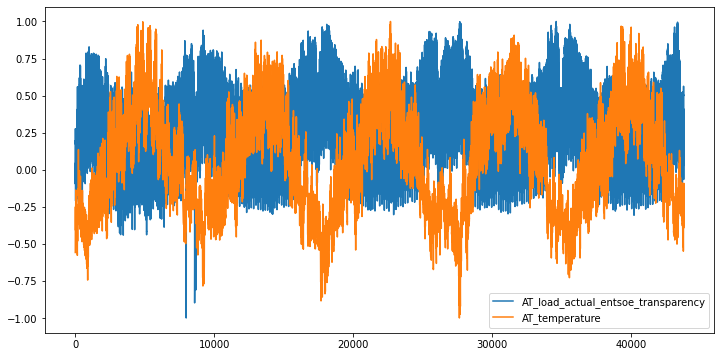

In [8]:
#Select, scale and plot the features as specified by the two_features list (see above)
selected_features, scalers = dh.scale_all(df_to_scale, two_features)
selected_features.plot(figsize = (12, 6), use_index = False)
print("Currently used scalers:")
print(scalers)

As you can see, both of our features (load and temperature for Austria) have now been scaled to fit within the same range (between -1 and 1).

Let's say we also wanted to include the weekday data from the data set in our training. Let us first take a look at what the weekday features look like. Here are the first 500 hours (approx. 3 weeks) of weekday_0:

<AxesSubplot:>

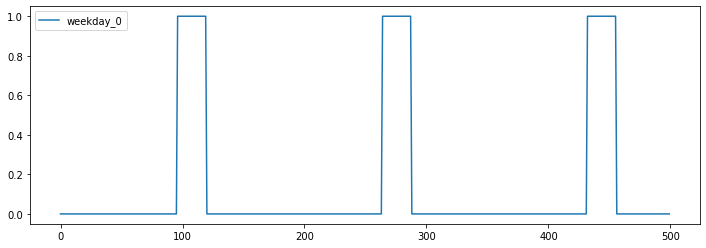

In [9]:
df_to_scale[:500].plot(kind='line',y='weekday_0', figsize = (12, 4), use_index = False)

As we can see, these features are already within the range [0,1] and thus don't need to be scaled. So we can include them in a second feature group called 'aux'. Note, features which we deliberately aren't scaling should go in a group with this name.

The value of the "feature_groups" key in the config.json could then look like this:

In [10]:
feature_groups = [
    {
        "name": "main",
        "scaler": [
            "minmax",
            0.0,
            1.0
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
            "AT_temperature"
        ]
    },
    {
        "name": "aux",
        "scaler": None,
        "features": [
            "weekday_0",
            "weekday_1",
            "weekday_2",
            "weekday_3",
            "weekday_4",
            "weekday_5",
            "weekday_6"
        ]
    }
]

We now have two feature groups, 'main' (which uses the 'minmax' scaler, this time with a range between 0 and 1) and 'aux' (which uses no scaler):

Currently used scalers:
{'main': MinMaxScaler(feature_range=(0.0, 1.0)), 'aux': None}


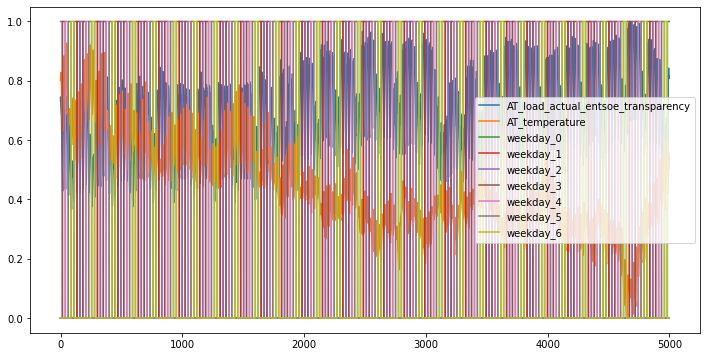

In [11]:
#Select, scale and plot the features as specified by feature_groups (see above)
selected_features, scalers = dh.scale_all(df_to_scale,feature_groups)
selected_features[23000:28000].plot(figsize = (12, 6), use_index = False)
print("Currently used scalers:")
print(scalers)

We can see that all of our selected features now fit between 0 and 1. From this point onward, train.py will only work with our selected, scaled features.

In [12]:
print("Currently selected and scaled features: ")
print(selected_features.columns)

Currently selected and scaled features: 
Index(['AT_load_actual_entsoe_transparency', 'AT_temperature', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object')


### Selecting scalers

When selecting which scalers to use, it is important that whichever one we choose does not adversely affect the shape of the distribution of our data, as this would distort our results. For example, this is the distribution of the feature "AT_load_actual_entsoe_transparency" before scaling:

<AxesSubplot:ylabel='Density'>

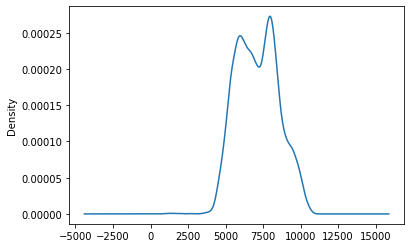

In [13]:
df_unscaled = pd.read_csv("../data/opsd.csv", sep=";", index_col=0)
df_unscaled["AT_load_actual_entsoe_transparency"].plot.kde()

And this is the distribution after scaling using the minmax scaler, as we did above: 

<AxesSubplot:ylabel='Density'>

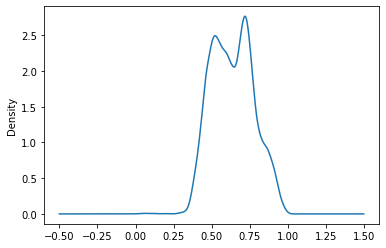

In [14]:
selected_features["AT_load_actual_entsoe_transparency"].plot.kde()

It is clear that in both cases, the distribution functions have a similar shape. The axes are scaled differently, but both graphs have maxima to the right of zero. On the other hand, this is what the distribution looks like if we use the robust scaler on this data:

<AxesSubplot:ylabel='Density'>

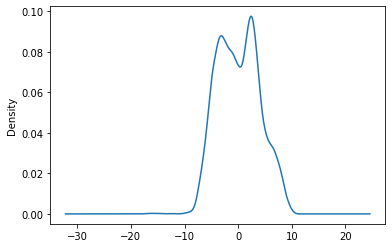

In [15]:
feature_robust = [
    {
        "name": "main",
        "scaler": [
            "robust",
            0.25, 
            0.75
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
        ]
    }
]

selected_feat_robust, scalers_robust = dh.scale_all(df_to_scale,feature_robust)

selected_feat_robust["AT_load_actual_entsoe_transparency"].plot.kde()

Not only have the axes been scaled, but the data has also been shifted so that the maxima are centered around zero. The same problem can be observed with the "standard" scaler:

<AxesSubplot:ylabel='Density'>

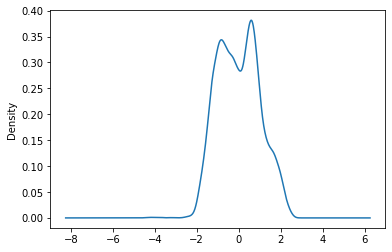

In [16]:
feature_std = [
    {
        "name": "main",
        "scaler": [
            "standard"
        ],
        "features": [
            "AT_load_actual_entsoe_transparency",
        ]
    }
]

selected_feat_std, scalers_std = dh.scale_all(df_to_scale,feature_std)

selected_feat_std["AT_load_actual_entsoe_transparency"].plot.kde()

As a result, the minmax scaler is the best option for this feature

## 3. Creating a dataframe to log training results

Having already filled any missing values in our data, and scaled and selected the features we want to use for training,
at this point we use the function 'proloaf.loghandler.create_log' to create a dataframe which will log the results of our training. 

This dataframe is saved as a .csv file at the end of the main training run. This allows different training runs, e.g. using new data or different parameters, to be compared with one another, so that we can monitor any changes in performance and compare the most recent run to the best performance achieved so far.

'create_log' creates the dataframe by getting which features we'll be logging from the [log.json file](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/log/), and then:
- loading an existing log file (from MAIN_PATH/\<log_path\>/\<model_name\>/\<model_name\>+"_training.csv" - see the [config.json explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/) for more information) 
- or creating a new dataframe from scratch, with the required features.

The newly created dataframe, log_df, is used at various later points in train.py (see sections [4](#4.-Exploration), [6](#6.-Main-run---training-the-model) and [7](#7.-Updating-the-config,-saving-the-model-&-logs) for more info).

## 4. Exploration

From this point on, it is assumed that we are working with prepared and scaled data (see earlier sections for more details).

The exploration phase is optional, and will only be carried out if the 'exploration' key in the config.json file is set to 'true'. The purpose of exploration is to tune our hyperparameters before the main training run. This is done by using [Optuna](https://optuna.org/) to optimize our [objective function](#Objective-function). Optuna iterates through a number of trials - either a fixed number, or until timeout (as specified in the tuning.json file, [see below](#tuning.json) for more info) - with the purpose of finding the hyperparameter settings that result in the smallest validation loss. This is an indicator of the quality of the prediction - the validation loss is the discrepancy between the predicted values and the actual values (targets) from the validation dataset, as determined by one of the metrics from [proloaf.metrics](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/reference/proloaf/proloaf/proloaf/eval_metrics.html). The metric used is specified when train.py is called.

Once Optuna is done iterating, a summary of the trials is printed (number of trials, details of the best trial), and if the new best trial represents an improvement over the previously logged best, you will be prompted about whether you would like to overwrite the config.json with the newly found hyperparameters, so that they can be used for future training. 

Optuna also has built-in paralellization, which we can opt to use by setting the 'parallel_jobs' key in the config.json to 'true'.

### Objective function
The previously mentioned objective function is a callable which Optuna uses for its optimization. In our case, it is the function 'mh.tuning_objective', which does the following per trial:
- Suggests values for each hyperparameter as per the [tuning.json](#tuning.json)
- Creates (see [section 5](#5.-Main-run---creating-the-training-model)) and trains (see  [section 6](#6.-Main-run---training-the-model)) a model using these hyperparameters and our selected features and scalers 
- Returns a score for the model in the form of the validation loss after training.

### tuning.json
The tuning.json file ([see explainer](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/#tuning-config) is located in the same folder as the other configs, under proloaf/targets/\<model name\>, and contains information about the hyperparameters to be tuned, as well as settings that limit how long Optuna should run. It can look like this, for example:

```json
{
  "number_of_tests": 100,
  "settings": 
  {
      "learning_rate": {
          "function": "suggest_loguniform",
          "kwargs": {
              "name": "learning_rate",
              "low": 0.000001,
              "high": 0.0001
          }
      },
      "batch_size": {
          "function": "suggest_int",
          "kwargs": {
              "name": "batch_size",
              "low": 32,
              "high": 120
          }
     }
  }
}
```
- "number_of_tests": 100 here means that Optuna will stop after 100 trials. Alternatively, "timeout": \<number in seconds\> would limit the maximum duration for which Optuna would run. If both are specified, Optuna will stop whenever the first criterion is met. If neither are specified, Optuna will wait for a termination signal (Ctrl+C or SIGTERM).

- The "settings" keyword has a dictionary as its value. This dictionary contains keywords for each of the hyperparameters that Optuna is to optimize, e.g. "learning_rate", "batch_size". 

- Each hyperparameter keyword takes yet another dictionary as a value, with the keywords "function" and "kwargs"

  - "function" takes as its value a function name beginning with "suggest_..." as described in the [Optuna docs](https://optuna.readthedocs.io/en/v1.4.0/reference/trial.html#optuna.trial.Trial.suggest_loguniform). These "suggest" functions are used to suggest hyperparameter values by sampling from a range with the relevant distribution.
  
  - "kwargs" has keywords for the arguments required by the "suggest" functions, typically "low" and "high" for the start and endpoints of the desired ranges as well as a "name" keyword which stores the hyperparameter name. 

### Notes
- When running train.py using Gitlab CI, the prompt about whether to overwrite the config.json with the newly found values  is disabled (as well as all other similar prompts).
- Though the objective function takes log_df (from the previous section) as a parameter, as it is required by the 'train' function, none of the training runs from this exploration phase are actually logged. Only the main run is logged. (See the next section for more)

## 5. Main run - creating the training model

Now that the data is free of missing values, we've selected which features we'll use, and the (optional) hyperparameter exploration is done, we are almost ready to create the model that will be used for the training. 

The last step we need to take before we can do that is to split our data into training, validation and testing sets. During this process, we also transition from using the familiar Dataframe structure we've been using up until now, to using a new custom structure called CustomTensorData.

### Splitting the data
We do this using the function 'proloaf.datahandler.transform', which splits our 'selected_features' dataframe into three new dataframes for the three sets outlined above. It does this according to the 'train_split' and 'validation_split' parameters in the config file, as follows:

Each of the 'split' parameters are multiplied with the length of the 'selected_features' dataframe, with the result converted to an integer. These new integer values are the indices for the split. 
e.g. For 'train_split' = 0.6 and 'validation_split'= 0.8, the first 60% of the data entries would be stored in the new training dataframe, with the next 20% going to the validation dataframe, and the final 20% used for the testing dataframe.

### Transformation into Tensors
Each of the three new dataframes is then transformed into the new CustomTensorData structure. This is done because the new structure is better suited for use with our RNN, and it is accomplished using 'proloaf.tensorloader.make_dataloader'.

A single CustomTensorData structure also has three components, each of which is comprised of a different set of features as defined in the config file:
- inputs1 - Encoder features: Features used as input for the encoder RNN. They provide information from a certain number of timesteps leading up to the period we wish to forecast i.e. from historical data.
- inputs2 - Decoder features: Features used as input for the decoder RNN. They provide information from the same time steps as the period we wish to forecast i.e. from data about the future that we know in advance, e.g. weather forecasts, day of the week, etc. 
- targets - The features we are trying to forecast.

These three components contain the features described above, but reorganized from the familiar tabular Dataframe format into a series of samples of a given length ([horizon](#Horizons)).
To understand this change, please consider the image below, which focuses on a single feature that is only 7 time steps long. (Feature 1 - with data that is merely illustrative)


![Tensor Structure](figures/tensor-structure.jpg)

The final format, as seen in the two examples on the right, consists of a number of samples (rows) of a given length (horizon), such that the first sample begins at the first time step of the range given to 'make_dataloader', and the last sample ends at the last time step in the aforementioned range. Each consecutive sample also begins one time step later than the previous sample (the one above it).

When we consider a set of multiple features (with many more than 7 timesteps), each feature is transformed individually and then all features are combined into a 3D Tensor, as depicted in the following image:

![3D Tensor](figures/3d-tensor.jpg)

### Horizons
So far, we have been using the term 'horizon' to refer to how many time steps are contained in one sample in our Custom Tensor structure. However, the three components (inputs1, inputs2 and targets) do not all share the same horizon length. In fact, there are two different parameters for horizon length, namely 'history_horizon', and 'forecast_horizon', and the different components use them as illustrated in the following diagram:

![Horizons](figures/horizon.jpg)

As we can see, sample 1 of inputs1 contains 'history_horizon' timesteps up to a certain point, while sample 1 of inputs2 and targets contain the 'forecast_horizon' timesteps that follow from that point onwards. This is because, as previously mentioned, inputs1 provides historical data, while inputs2 and targets both provide "future data" - data from the future that we know ahead of making our forecast.

**NB:** our "future data" can include uncertainty, for example, if we use existing forecasts as input.

With increasing sample number, we have a kind of moving window which shifts towards the right in the image above. 
So that all three components contain the same number of samples, the inputs1 tensor does not include the final 'forecast_horizon' timesteps, while inputs2 and targets do not contain the first 'history_horizon' timesteps.

**Note:** for illustration purposes, the above image shows which timesteps are in a given sample of the three components, in relation to the original dataframe. The components are nevertheless at this point already stored in the custom tensor structure described earlier in this subsection.

### Model Creation

The final step in this stage is to create the model which we will be training. We do this using 'proloaf.modelhandler.make_model'. This function takes the number of features in component 1 and in component 2 (inputs1 and inputs2) of the training tensor, as well as our scalers from [section 2](#2.-Selecting-and-scaling-features) of this guide and other parameters from the config file, and returns a EncoderDecoder model as defined in 'proloaf.models'. 

## 6. Main run - training the model

At this point, we have everything we need to train our model: our training, validation and testing datasets, stored as CustomTensorData structures, and the instantiated EncoderDecoder model we are going to be training. We give these along with the hyperparameters in our config file (e.g. learning rate, batch size etc.) to the function 'proloaf.modelhandler.train'. This function returns: 
 - a trained model
 - our logging dataframe (see [section 3](#3.-Creating-a-dataframe-to-log-training-results)) updated with the results of the training
 - the minimum validation loss after training
 - the model's score as calculated by the function 'performance_test', in our case using the metric 'mis' (Mean Interval Score)  as defined in 'proloaf.metrics'
 
What follows is a short breakdown of what 'proloaf.modelhandler.train' does. 
 
**Reminder:** 'loss' generally refers to a measure of how far off our predictions are from the actual values (targets) we are trying to predict.

### How training works

Training lasts for a number of epochs, given by the parameter 'max_epochs' in the config file.
During each epoch, we perform the training step, followed by the validation step.

#### Training step: 
Use .train() on the model to set it in training mode, then loop through every sample in our training data tensor, and in each iteration of the loop:
- get the model's prediction using the current sample of inputs1 and inputs2
- zero the gradients of our optimizer
- calculate the loss of the prediction we just made for this sample (using whichever metric is specified in the config)
- compute new gradients using loss.backward()
- update the optimizer's parameters (by taking an optimization step) using the new gradients
- update the epoch loss (the loss for the current sample is divided by the total number of samples in the training data and added to the current epoch loss)

This step iteratively teaches the model to produce better predictions. 

#### Validation step:
Use .eval() on the model to set it in validation mode, then loop through every sample in our validation data tensor, and in each iteration of the loop:
- get the model's prediction using the current sample of inputs1 and inputs2
- update the validation loss (the loss for the current sample is calculated using whichever metric is specified in the config, then divided by the total number of samples in the validation data and added to the current validation loss)

This step gives us a way to track whether our model is improving, by validating the training using new data, to ensure that our model doesn't only work on our specific training data, but that it is actually being trained to predict the behaviour of our target feature. 

The training uses early stopping, which basically means that it stops before 'max_epochs' iterations have been reached, if and when a certain number of epochs go by without any improvement to the model.

**Note:** If you are using Tensorboard's SummaryWriter to log training performance, this is when it gets logged. 

#### Testing step:
Here, the function 'performance_test' is used to calculate the model's score using the testing data set. As mentioned at the top of this section, this function calculates the Mean Interval Score along the horizon. This score is saved along with the model, see [section 7]((#7.-Updating-the-config,-saving-the-model-&-logs))


## 7. Updating the config, saving the model & logs

The last thing we need to do is save our current model and the relevant scores and logs, so that we can use it in the future and monitor changes in performance.

First, the model is saved using 'modelhandler.save'. By default, this function only saves the model if the most recently achieved score is better than the previous best. In this case, and only if running in exploration mode, the config is updated with the most recent parameters before saving. <br>
If no improvement was achieved, the model can still be saved by opting to do so when prompted. In this case, the config parameters will not be updated before saving. 

Saving the model entails calling torch.save() to store the model at the location given by the config parameter "output_path", and then saving the config to "config_path" using the function 'proloaf.confighandler.write_config'.

Lastly, the logs are saved using the function 'proloaf.loghandler.end_logging', which writes the logs to a .csv stored at:<br>
MAIN_PATH/\<log_path\>/\<model_name\>/\<model_name\>+"_training.csv", (the same location as where the log file was read in from) 


**Note:** Things work a little differently if using Tensorboard logging (TODO: expand) <br>
In this case, when the 'modelhandler.train' function is called during the exploration phase (see [section 4](#4.-Exploration)) the config is automatically updated with the hyperparameter values from the latest trial, right after that trial ends. 